In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import pickle
import six
import sys
sys.modules['sklearn.externals.six'] = six

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

from sklearn.utils import resample
from imblearn.over_sampling import SMOTENC,RandomOverSampler
from sklearn.preprocessing import LabelEncoder

import imblearn.over_sampling
#from imblearn.over_sampling import KMeansSMOTE
import sklearn.impute
#from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator

from sklearn.model_selection import train_test_split

sns.set()

In [77]:
#loading data set

df = pd.read_csv("hypothyroid.csv")
df.head(5)

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,negative
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,negative
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,negative
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,negative
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,negative


In [78]:
df.columns

Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'TSH',
       'T3_measured', 'T3', 'TT4_measured', 'TT4', 'T4U_measured', 'T4U',
       'FTI_measured', 'FTI', 'TBG_measured', 'TBG', 'referral_source',
       'Class'],
      dtype='object')

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3772 non-null   object
 1   sex                        3772 non-null   object
 2   on_thyroxine               3772 non-null   object
 3   query_on_thyroxine         3772 non-null   object
 4   on_antithyroid_medication  3772 non-null   object
 5   sick                       3772 non-null   object
 6   pregnant                   3772 non-null   object
 7   thyroid_surgery            3772 non-null   object
 8   I131_treatment             3772 non-null   object
 9   query_hypothyroid          3772 non-null   object
 10  query_hyperthyroid         3772 non-null   object
 11  lithium                    3772 non-null   object
 12  goitre                     3772 non-null   object
 13  tumor                      3772 non-null   object
 14  hypopitu

In [80]:
df.shape

(3772, 30)

In [81]:
df["Class"].unique()

array(['negative', 'compensated_hypothyroid', 'primary_hypothyroid',
       'secondary_hypothyroid'], dtype=object)

Ouptut class also has 4 distinct categories.

In [82]:
df.describe()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
count,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,...,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772
unique,94,3,2,2,2,2,2,2,2,2,...,2,242,2,147,2,235,1,1,5,4
top,59,F,f,f,f,f,f,f,f,f,...,t,?,t,?,t,?,f,?,other,negative
freq,95,2480,3308,3722,3729,3625,3719,3719,3713,3538,...,3541,231,3385,387,3387,385,3772,3772,2201,3481


We can see from the data description that there are no missing values. But if we check the dataset the missing values are replaced with invalid values like '?'. Let's replace such values with 'nan' and check for missing values again.

In [83]:
#checking number of invalid value like '?' present in each column

for column in df.columns:
    count = df[column][df[column]=='?'].count()
    if count!=0:
        print(column, count)

age 1
sex 150
TSH 369
T3 769
TT4 231
T4U 387
FTI 385
TBG 3772


So these are the columns which have missing values but missing values are replaced with '?'. We will replace these values with 'nan' and then do imputation of these missing values.

Also, we can see that for column 'TBG' all the values are missing. So we will drop this column as it is of no use to us.

In [84]:
df = df.drop(['TBG'],axis =1)

Also, looking to the dataset, we can see that some columns are with true and false value are just the indication that whether the next column has values or not. Let's see an example:

In [85]:
df[['T4U_measured','T4U']].head()

,T4U_measured,T4U
0,t,1.14
1,f,?
2,t,0.91
3,f,?
4,t,0.87


Since, we are any ways going to handle the missing values, there is no point of having such columns in our dataset.

Let's drop such columns as well.

In [86]:
df = df.drop(['TSH_measured','T3_measured','TT4_measured','T4U_measured','FTI_measured','TBG_measured'],axis =1)

In [87]:
# Now let's replace the '?' values with numpy nan

for column in df.columns:
    count = df[column][df[column]=='?'].count()
    if count!=0:
        df[column] = df[column].replace('?',np.nan)

In [88]:
for column in df.columns:
    count = df[column][df[column]=='?'].count()
    if count==0:
        print(column, count)

age 0
sex 0
on_thyroxine 0
query_on_thyroxine 0
on_antithyroid_medication 0
sick 0
pregnant 0
thyroid_surgery 0
I131_treatment 0
query_hypothyroid 0
query_hyperthyroid 0
lithium 0
goitre 0
tumor 0
hypopituitary 0
psych 0
TSH 0
T3 0
TT4 0
T4U 0
FTI 0
referral_source 0
Class 0


All '?' values replaced with nan. Now let's deal with missing values.

In [89]:
df.isnull().sum()

age                            1
sex                          150
on_thyroxine                   0
query_on_thyroxine             0
on_antithyroid_medication      0
sick                           0
pregnant                       0
thyroid_surgery                0
I131_treatment                 0
query_hypothyroid              0
query_hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH                          369
T3                           769
TT4                          231
T4U                          387
FTI                          385
referral_source                0
Class                          0
dtype: int64

In [90]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,referral_source,Class
0,41,F,f,f,f,f,f,f,f,f,...,f,f,f,1.3,2.5,125,1.14,109,SVHC,negative
1,23,F,f,f,f,f,f,f,f,f,...,f,f,f,4.1,2,102,NaN,NaN,other,negative
2,46,M,f,f,f,f,f,f,f,f,...,f,f,f,0.98,NaN,109,0.91,120,other,negative
3,70,F,t,f,f,f,f,f,f,f,...,f,f,f,0.16,1.9,175,NaN,NaN,other,negative
4,70,F,f,f,f,f,f,f,f,f,...,f,f,f,0.72,1.2,61,0.87,70,SVI,negative


Since the values are categorical, we have to change them to numerical before we use any imputation techniques.

We can use get dummies but since most of the columns have only two distinct categories we will use mapping for them. Why? Because since there are only two categories then the two columns formed after get dummies will both have very high correaltion since they both explain the same thing. So in anyway we will have to drop one of the columns. That's why let's use mapping for such columns. For columns with more than two categories we will use get dummies.

In [91]:
# In sex column we have to map 0 for F and 1 for M

df['sex'] = df['sex'].map({'F' : 0, 'M' : 1})

# except for 'Sex' column all the other columns with two categorical data have same value 'f' and 't'.
# let's write map them all in one go
for column in df.columns:
    if  len(df[column].unique())==2:
        df[column] = df[column].map({'f' : 0, 't' : 1})
        
# this will map all the rest of the columns as we require.

In [92]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,referral_source,Class
0,41,0.0,0,0,0,0,0,0,0,0,...,0,0,0,1.3,2.5,125,1.14,109,SVHC,negative
1,23,0.0,0,0,0,0,0,0,0,0,...,0,0,0,4.1,2,102,NaN,NaN,other,negative
2,46,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0.98,NaN,109,0.91,120,other,negative
3,70,0.0,1,0,0,0,0,0,0,0,...,0,0,0,0.16,1.9,175,NaN,NaN,other,negative
4,70,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0.72,1.2,61,0.87,70,SVI,negative


Now there are only one column left with more than 2 categories that is referral_source

In [93]:
df['referral_source'].unique()

array(['SVHC', 'other', 'SVI', 'STMW', 'SVHD'], dtype=object)

In [94]:
# we will use get_dummies for refrerral_source
df = pd.get_dummies(df, columns=['referral_source'])

In [95]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4,T4U,FTI,Class,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
0,41,0.0,0,0,0,0,0,0,0,0,...,2.5,125,1.14,109,negative,False,True,False,False,False
1,23,0.0,0,0,0,0,0,0,0,0,...,2,102,NaN,NaN,negative,False,False,False,False,True
2,46,1.0,0,0,0,0,0,0,0,0,...,NaN,109,0.91,120,negative,False,False,False,False,True
3,70,0.0,1,0,0,0,0,0,0,0,...,1.9,175,NaN,NaN,negative,False,False,False,False,True
4,70,0.0,0,0,0,0,0,0,0,0,...,1.2,61,0.87,70,negative,False,False,False,True,False


Now our ouptut class also has 4 distinct categories. There is no sense of using get dummies with our Output class, so we will just map them. Let's use LabelEncoder function for this.

In [96]:
df['Class'].unique()

array(['negative', 'compensated_hypothyroid', 'primary_hypothyroid',
       'secondary_hypothyroid'], dtype=object)

In [97]:
#lblEn = LabelEncoder()
#df['Class'] =lblEn.fit_transform(df['Class'])

encode = LabelEncoder().fit(df['Class'])

df['Class'] = encode.transform(df['Class'])

# we will save the encoder as pickle to use when we do the prediction. We will need to decode the predcited values
# back to original

file = "enc.pickle"
pickle.dump(encode, open(file, "wb"))

In [98]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4,T4U,FTI,Class,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
0,41,0.0,0,0,0,0,0,0,0,0,...,2.5,125,1.14,109,1,False,True,False,False,False
1,23,0.0,0,0,0,0,0,0,0,0,...,2,102,NaN,NaN,1,False,False,False,False,True
2,46,1.0,0,0,0,0,0,0,0,0,...,NaN,109,0.91,120,1,False,False,False,False,True
3,70,0.0,1,0,0,0,0,0,0,0,...,1.9,175,NaN,NaN,1,False,False,False,False,True
4,70,0.0,0,0,0,0,0,0,0,0,...,1.2,61,0.87,70,1,False,False,False,True,False


In [99]:
df["Class"].value_counts()

Class
1    3481
0     194
2      95
3       2
Name: count, dtype: int64

In [100]:
df.describe(include = "all")

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4,T4U,FTI,Class,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
count,3771,3622.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,...,3003,3541,3385,3387,3772.000000,3772,3772,3772,3772,3772
unique,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,69,241,146,234,NaN,2,2,2,2,2
top,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,101,0.99,100,NaN,False,False,False,False,True
freq,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,238,71,95,73,NaN,3660,3386,3733,2738,2201
mean,NaN,0.315295,0.123012,0.013256,0.011400,0.038971,0.014051,0.014051,0.015642,0.062036,...,NaN,NaN,NaN,NaN,0.974814,NaN,NaN,NaN,NaN,NaN
std,NaN,0.464698,0.328494,0.114382,0.106174,0.193552,0.117716,0.117716,0.124101,0.241253,...,NaN,NaN,NaN,NaN,0.279508,NaN,NaN,NaN,NaN,NaN
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN


Now that we have encoded all our Categorical values. Let's start with imputing the missing values.

In [101]:
imputer=sklearn.impute.KNNImputer(n_neighbors=3, weights='uniform',missing_values=np.nan)
new_array=imputer.fit_transform(df) # impute the missing values
# convert the nd-array returned in the step above to a Dataframe
new_df=pd.DataFrame(data=np.round(new_array), columns=df.columns)

In [102]:
new_df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4,T4U,FTI,Class,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,125.0,1.0,109.0,1.0,0.0,1.0,0.0,0.0,0.0
1,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,102.0,1.0,108.0,1.0,0.0,0.0,0.0,0.0,1.0
2,46.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,109.0,1.0,120.0,1.0,0.0,0.0,0.0,0.0,1.0
3,70.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,175.0,1.0,177.0,1.0,0.0,0.0,0.0,0.0,1.0
4,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,61.0,1.0,70.0,1.0,0.0,0.0,0.0,1.0,0.0


In [103]:
new_df.isnull().sum()

age                          0
sex                          0
on_thyroxine                 0
query_on_thyroxine           0
on_antithyroid_medication    0
sick                         0
pregnant                     0
thyroid_surgery              0
I131_treatment               0
query_hypothyroid            0
query_hyperthyroid           0
lithium                      0
goitre                       0
tumor                        0
hypopituitary                0
psych                        0
TSH                          0
T3                           0
TT4                          0
T4U                          0
FTI                          0
Class                        0
referral_source_STMW         0
referral_source_SVHC         0
referral_source_SVHD         0
referral_source_SVI          0
referral_source_other        0
dtype: int64

Now there are no missing values in our new dataset.

Let's check the distribution for our continous data in the dataset:

C:\Users\Biswarup Naha\AppData\Local\Temp\ipykernel_4412\695031981.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df[column])
C:\Users\Biswarup Naha\AppData\Local\Temp\ipykernel_4412\695031981.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df[column])
C:\Users\Biswarup Naha\App

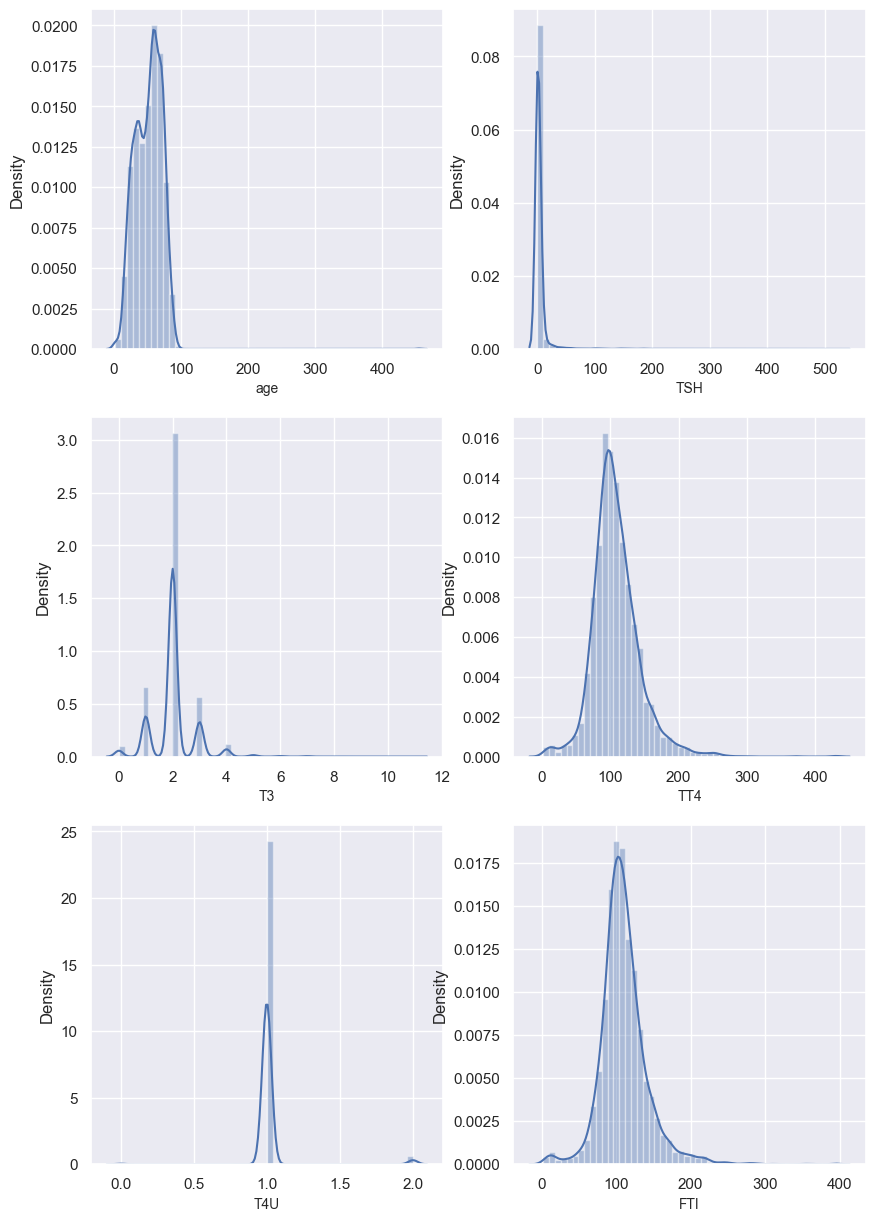

In [104]:
columns = ['age','TSH','T3','TT4','T4U','FTI']

plt.figure(figsize=(10,15),facecolor='white')
plotnumber = 1

for column in columns:
    ax = plt.subplot(3,2,plotnumber)
    sns.distplot(new_df[column])
    plt.xlabel(column,fontsize=10)
    plotnumber+=1
plt.show()

Let's do some transformations to the data and see if it improves the plot.

Before doing log transformation , let's add 1 to each valuue in the column to handle exception when we try to find log of '0'.

C:\Users\Biswarup Naha\AppData\Local\Temp\ipykernel_4412\1974254401.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(new_df[column]))
C:\Users\Biswarup Naha\AppData\Local\Temp\ipykernel_4412\1974254401.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(new_df[column]))
C:\Users

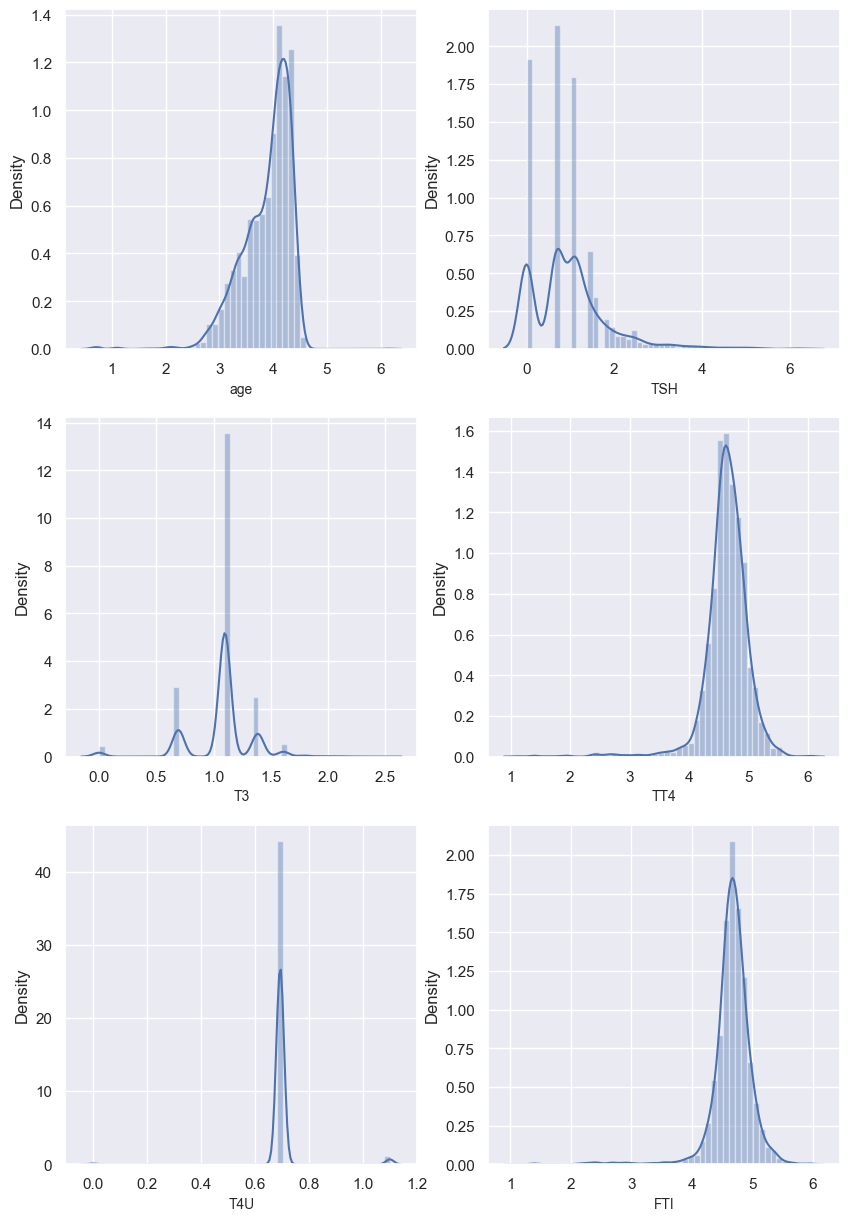

In [105]:
columns = ['age','TSH','T3','TT4','T4U','FTI']

plt.figure(figsize=(10,15),facecolor='white')
plotnumber = 1

for column in columns:
    new_df[column]+=1
    ax = plt.subplot(3,2,plotnumber)
    sns.distplot(np.log(new_df[column]))
    plt.xlabel(column,fontsize=10)
    plotnumber+=1
plt.show()

After log transformation, rest of the columns look fine but 'TSH' has a weird trend.

It won't give much of information so let's drop this column.

In [106]:
new_df = new_df.drop(['TSH'],axis=1)

let's see how balanced our dataset in terms of given target classes:

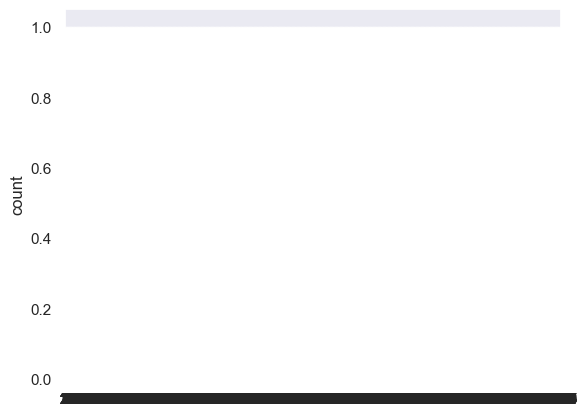

In [107]:
# let's see how data is distributed for every column for every individual id
# the graph plot below is for individual ids. Press 1 in the  input box below the graph to continue viewing graph for each id!!

# plt.figure(figsize=(20,25), facecolor='white')
# plotnumber = 1
# plt_data = df.drop(['age'], axis =1)

# for column in plt_data:
#     ax = plt.subplot(6,5,plotnumber)
#     sns.countplot(plt_data[column])
#     plt.xlabel(column,fontsize=10)
#     plotnumber+=1
# plt.show()


sns.countplot(new_df['Class'])
plt.show()

We can clerly see that the dataset is highly imbalanced.

We will use a python library known as imbalanced-learn to deal with imbalanced data. Imbalanced learn has an algorithm called RandomOverSampler.

In [108]:
x = new_df.drop(['Class'],axis=1)
y = new_df['Class']
rdsmple = RandomOverSampler()
x_sampled,y_sampled  = rdsmple.fit(x,y)

TypeError: cannot unpack non-iterable RandomOverSampler object

In [ ]:
x_sampled.shape

(13924, 25)

In [ ]:
x_sampled = pd.DataFrame(data = x_sampled, columns = x.columns)
x_sampled.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,T3,TT4,T4U,FTI,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,126.0,2.0,110.0,0.0,1.0,0.0,0.0,0.0
1,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,103.0,2.0,109.0,0.0,0.0,0.0,0.0,1.0
2,47.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,110.0,2.0,121.0,0.0,0.0,0.0,0.0,1.0
3,71.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,176.0,2.0,178.0,0.0,0.0,0.0,0.0,1.0
4,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,62.0,2.0,71.0,0.0,0.0,0.0,1.0,0.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


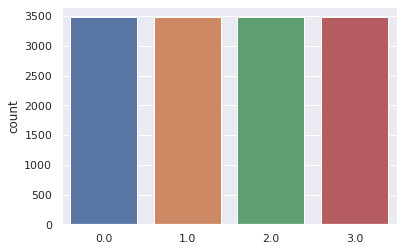

In [ ]:
sns.countplot(y_sampled)

# Model *Building*

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics  import roc_auc_score,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [ ]:
x_sampled.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,T3,TT4,T4U,FTI,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,126.0,2.0,110.0,0.0,1.0,0.0,0.0,0.0
1,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,103.0,2.0,109.0,0.0,0.0,0.0,0.0,1.0
2,47.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,110.0,2.0,121.0,0.0,0.0,0.0,0.0,1.0
3,71.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,176.0,2.0,178.0,0.0,0.0,0.0,0.0,1.0
4,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,62.0,2.0,71.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
x_sampled.isnull().sum()

age                          0
sex                          0
on_thyroxine                 0
query_on_thyroxine           0
on_antithyroid_medication    0
sick                         0
pregnant                     0
thyroid_surgery              0
I131_treatment               0
query_hypothyroid            0
query_hyperthyroid           0
lithium                      0
goitre                       0
tumor                        0
hypopituitary                0
psych                        0
T3                           0
TT4                          0
T4U                          0
FTI                          0
referral_source_STMW         0
referral_source_SVHC         0
referral_source_SVHD         0
referral_source_SVI          0
referral_source_other        0
dtype: int64

In [ ]:
y_sampled

array([1., 1., 1., ..., 3., 3., 3.])

### Clustering of the data

In [ ]:
def elbow_plot(data):
        """
                        Method Name: elbow_plot
                        Description: This method saves the plot to decide the optimum number of clusters to the file.
                        Output: A picture saved to the directory
                        On Failure: Raise Exception

        """
        
        wcss=[] # initializing an empty list
        try:
            for i in range (1,11):
                kmeans=KMeans(n_clusters=i,init='k-means++',random_state=42) # initializing the KMeans object
                kmeans.fit(data) # fitting the data to the KMeans Algorithm
                wcss.append(kmeans.inertia_)
            plt.plot(range(1,11),wcss) # creating the graph between WCSS and the number of clusters
            plt.title('The Elbow Method')
            plt.xlabel('Number of clusters')
            plt.ylabel('WCSS')

            plt.savefig('K-Means_Elbow.PNG') # saving the elbow plot locally
            # finding the value of the optimum cluster programmatically
            kn = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')
            print('The optimum number of clusters is: '+str(kn.knee)+' . Exited the elbow_plot method of the KMeansClustering class')
            return kn.knee

        except Exception as e:
          print(e)

The optimum number of clusters is: 3 . Exited the elbow_plot method of the KMeansClustering class


3

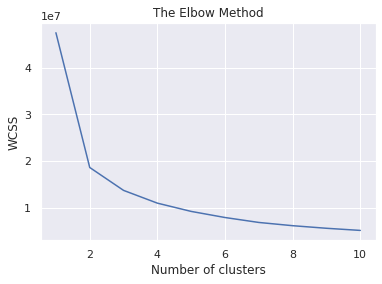

In [ ]:
elbow_plot(x_sampled)

In [ ]:
def create_clusters(data,number_of_clusters):
        """
                                Method Name: create_clusters
                                Description: Create a new dataframe consisting of the cluster information.
                                Output: A datframe with cluster column
                                On Failure: Raise Exception

      """
        
        try:
            kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++', random_state=42)
            
            y_kmeans=kmeans.fit_predict(data) #  divide data into clusters


            data['Cluster']=y_kmeans  # create a new column in dataset for storing the cluster information
            print('succesfully created '+str(f"{number_of_clusters}")+ ' clusters. Exited the create_clusters method of the KMeansClustering class')
            return data

        except Exception as e:
          print(e)
        

In [ ]:
#Creating clusters
x_sampled = create_clusters(x_sampled,3)

succesfully created 3 clusters. Exited the create_clusters method of the KMeansClustering class


In [ ]:
x_sampled

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,T3,TT4,T4U,FTI,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other,Cluster
0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,126.0,2.0,110.0,0.0,1.0,0.0,0.0,0.0,1
1,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,103.0,2.0,109.0,0.0,0.0,0.0,0.0,1.0,2
2,47.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,110.0,2.0,121.0,0.0,0.0,0.0,0.0,1.0,1
3,71.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,176.0,2.0,178.0,0.0,0.0,0.0,0.0,1.0,1
4,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,62.0,2.0,71.0,0.0,0.0,0.0,1.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13919,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,23.0,2.0,58.0,0.0,0.0,0.0,0.0,1.0,0
13920,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,23.0,2.0,58.0,0.0,0.0,0.0,0.0,1.0,0
13921,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,49.0,2.0,55.0,0.0,0.0,0.0,0.0,1.0,0
13922,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,49.0,2.0,55.0,0.0,0.0,0.0,0.0,1.0,0


In [ ]:
#Adding data labels into x
x_sampled['Labels']=y_sampled

In [ ]:
x_sampled.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,T3,TT4,T4U,FTI,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other,Cluster,Labels
0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,126.0,2.0,110.0,0.0,1.0,0.0,0.0,0.0,1,1.0
1,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,103.0,2.0,109.0,0.0,0.0,0.0,0.0,1.0,2,1.0
2,47.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,110.0,2.0,121.0,0.0,0.0,0.0,0.0,1.0,1,1.0
3,71.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,176.0,2.0,178.0,0.0,0.0,0.0,0.0,1.0,1,1.0
4,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,62.0,2.0,71.0,0.0,0.0,0.0,1.0,0.0,2,1.0


In [ ]:
list_of_clusters=x_sampled['Cluster'].unique()
list_of_clusters

array([1, 2, 0], dtype=int32)

### Model on Cluster == 1

In [ ]:
cluster_data=x_sampled[x_sampled['Cluster']==1]

In [ ]:
cluster_data

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,T3,TT4,T4U,FTI,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other,Cluster,Labels
0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,126.0,2.0,110.0,0.0,1.0,0.0,0.0,0.0,1,1.0
2,47.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,110.0,2.0,121.0,0.0,0.0,0.0,0.0,1.0,1,1.0
3,71.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,176.0,2.0,178.0,0.0,0.0,0.0,0.0,1.0,1,1.0
5,19.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,184.0,2.0,142.0,0.0,0.0,0.0,0.0,1.0,1,1.0
8,67.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,124.0,2.0,133.0,0.0,0.0,0.0,1.0,0.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10221,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,112.0,2.0,137.0,1.0,0.0,0.0,0.0,0.0,1,2.0
10264,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,124.0,2.0,128.0,0.0,0.0,0.0,1.0,0.0,1,2.0
10268,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,124.0,2.0,128.0,0.0,0.0,0.0,1.0,0.0,1,2.0
10339,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,124.0,2.0,128.0,0.0,0.0,0.0,1.0,0.0,1,2.0


In [ ]:
cluster_features=cluster_data.drop(['Labels','Cluster'],axis=1)
cluster_label= cluster_data['Labels']

In [ ]:
# splitting the data into training and test set for each cluster one by one
x_train, x_test, y_train, y_test = train_test_split(cluster_features, cluster_label, test_size=1 / 3, random_state=355)

In [ ]:
def get_best_params_for_random_forest(train_x,train_y):
        """
                                Method Name: get_best_params_for_random_forest
                                Description: get the parameters for Random Forest Algorithm which give the best accuracy.
                                             Use Hyper Parameter Tuning.
                                Output: The model with the best parameters
                                On Failure: Raise Exception

        """
        print('Entered the get_best_params_for_random_forest method of the Model_Finder class')
        try:
            # initializing with different combination of parameters
            param_grid = {"n_estimators": [10, 50, 100, 130], "criterion": ['gini', 'entropy'],
                               "max_depth": range(2, 4, 1), "max_features": ['auto', 'log2']}

            clf = RandomForestClassifier()
        
            #Creating an object of the Grid Search class
            grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5,  verbose=3)
            #finding the best parameters
            grid.fit(train_x, train_y)

            #extracting the best parameters
            criterion = grid.best_params_['criterion']
            max_depth = grid.best_params_['max_depth']
            max_features = grid.best_params_['max_features']
            n_estimators = grid.best_params_['n_estimators']

            #creating a new model with the best parameters
            clf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion,
                                              max_depth=max_depth, max_features=max_features)
            # training the mew model
            clf.fit(train_x, train_y)
            
            print('Random Forest best params: '+str(f"{grid.best_params_}")+'. Exited the get_best_params_for_random_forest method of the Model_Finder class')

            return clf
        except Exception as e:
          raise Exception()


In [ ]:
def get_best_params_for_KNN(train_x, train_y):
        """
                                                Method Name: get_best_params_for_KNN
                                                Description: get the parameters for KNN Algorithm which give the best accuracy.
                                                             Use Hyper Parameter Tuning.
                                                Output: The model with the best parameters
                                                On Failure: Raise Exception

        """
        print('Entered the get_best_params_for_Ensembled_KNN method of the Model_Finder class')
        try:
            #initializing with different combination of parameters
            param_grid_knn = {
                'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
                'leaf_size' : [10,17,24,28,30,35],
                'n_neighbors':[4,5,8,10,11],
                'p':[1,2]
            }

            knn = KNeighborsClassifier()
            #Creating an object of the Grid Search class
            grid = GridSearchCV(knn, param_grid_knn, verbose=3,cv=5)
            # finding the best parameters
            grid.fit(train_x, train_y)

            # extracting the best parameters
            algorithm =grid.best_params_['algorithm']
            leaf_size = grid.best_params_['leaf_size']
            n_neighbors = grid.best_params_['n_neighbors']
            p  = grid.best_params_['p']

            # creating a new model with the best parameters
            knn = KNeighborsClassifier(algorithm=algorithm, leaf_size=leaf_size, n_neighbors=n_neighbors,p=p,n_jobs=-1)
            # training the mew model
            knn.fit(train_x, train_y)
            print('KNN best params: ' + str(f"{grid.best_params_}") + '. Exited the KNN method of the Model_Finder class')
            return knn

        except Exception as e:
            raise Exception()

In [ ]:
random_forest_classifier = get_best_params_for_random_forest(x_train,y_train)

Entered the get_best_params_for_random_forest method of the Model_Finder class
Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.681, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.721, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.684, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.686, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.726, total=   0.0s
[CV] criterion

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=50, score=0.681, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=50 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=50, score=0.681, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=50 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=50, score=0.684, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=50 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=50, score=0.686, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=50 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=50, score=0.686, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=100 
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=100, score=0.681, total=   0.2s
[CV] criterion=gini, max_depth=2, max_features=auto, n_e

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:   21.0s finished


In [ ]:
knn_classifier = get_best_params_for_KNN(x_train, y_train)

Entered the get_best_params_for_Ensembled_KNN method of the Model_Finder class
Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1, score=0.926, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1, score=0.899, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1, score=0.905, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1, score=0.905, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1, score=0.892, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2 ....

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2, score=0.908, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2, score=0.911, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2, score=0.908, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2, score=0.892, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=1, score=0.929, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=1, score=0.893, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_nei

[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:   25.4s finished


In [ ]:
def get_best_params_for_xgboost(train_x,train_y):
   """
                                      Method Name: get_best_params_for_xgboost
                                      Description: get the parameters for XGBoost Algorithm which give the best accuracy.
                                      Use Hyper Parameter Tuning.

                                      Output: The model with the best parameters
                                      On Failure: Raise Exception
                              
   """




        
   print('Entered the get_best_params_for_xgboost method of the Model_Finder class')
   try:
     # initializing with different combination of parameters
     param_grid_xgboost = {
    
                 'learning_rate': [0.5, 0.1, 0.01, 0.001],
                 'max_depth': [3, 5, 10, 20],
                 'n_estimators': [10, 50, 100, 200]
    
             }
     # Creating an object of the Grid Search class
     grid= GridSearchCV(XGBClassifier(objective='binary:logistic'),param_grid_xgboost, verbose=3,cv=5)
     # finding the best parameters
     grid.fit(train_x, train_y)
    
     # extracting the best parameters
     learning_rate = grid.best_params_['learning_rate']
     max_depth = grid.best_params_['max_depth']
     n_estimators = grid.best_params_['n_estimators']
    
     # creating a new model with the best parameters
     xgb = XGBClassifier(learning_rate=1, max_depth=5, n_estimators=50)
     # training the mew model
     xgb.fit(train_x, train_y)
     print('XGBoost best params: ' + str(f"{grid.best_params_}") + '. Exited the get_best_params_for_xgboost method of the Model_Finder class')
            

     return xgb
   except Exception as e:
     raise Exception()


In [ ]:
xgb_classifier = get_best_params_for_xgboost(x_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Entered the get_best_params_for_xgboost method of the Model_Finder class
Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] learning_rate=0.5, max_depth=3, n_estimators=10 .................
[CV]  learning_rate=0.5, max_depth=3, n_estimators=10, score=0.862, total=   0.2s
[CV] learning_rate=0.5, max_depth=3, n_estimators=10 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  learning_rate=0.5, max_depth=3, n_estimators=10, score=0.862, total=   0.0s
[CV] learning_rate=0.5, max_depth=3, n_estimators=10 .................
[CV]  learning_rate=0.5, max_depth=3, n_estimators=10, score=0.859, total=   0.0s
[CV] learning_rate=0.5, max_depth=3, n_estimators=10 .................
[CV]  learning_rate=0.5, max_depth=3, n_estimators=10, score=0.843, total=   0.0s
[CV] learning_rate=0.5, max_depth=3, n_estimators=10 .................
[CV]  learning_rate=0.5, max_depth=3, n_estimators=10, score=0.849, total=   0.0s
[CV] learning_rate=0.5, max_depth=3, n_estimators=50 .................
[CV]  learning_rate=0.5, max_depth=3, n_estimators=50, score=0.969, total=   0.2s
[CV] learning_rate=0.5, max_depth=3, n_estimators=50 .................
[CV]  learning_rate=0.5, max_depth=3, n_estimators=50, score=0.972, total=   0.1s
[CV] learning_rate=0.5, max_depth=3, n_estimators=50 .................
[CV]  learning_rate=0.5, max_depth=3, n_estimators=50, score=0.975, total=   0.2s


[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  2.9min finished


XGBoost best params: {'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 100}. Exited the get_best_params_for_xgboost method of the Model_Finder class


In [ ]:
def get_best_model(train_x,train_y,test_x,test_y):
        """
                                                Method Name: get_best_model
                                                Description: Find out the Model which has the best AUC score.
                                                Output: The best model name and the model object
                                                On Failure: Raise Exception

        """
        print('Entered the get_best_model method of the Model_Finder class')
        # create best model for KNN
        try:
            knn= get_best_params_for_KNN(train_x,train_y)
            prediction_knn = knn.predict_proba(test_x) # Predictions using the KNN Model

            if len(test_y.unique()) == 1: #if there is only one label in y, then roc_auc_score returns error. We will use accuracy in that case
                knn_score = accuracy_score(test_y, prediction_knn)
                print('Accuracy for knn:' + str(knn_score))  # Log AUC
            else:
                knn_score = roc_auc_score(test_y, prediction_knn, multi_class='ovr') # AUC for KNN
                print('AUC for knn:' + str(knn_score)) # Log AUC

            # create best model for Random Forest
            random_forest= get_best_params_for_random_forest(train_x,train_y)
            prediction_random_forest=random_forest.predict_proba(test_x) # prediction using the Random Forest Algorithm

            if len(test_y.unique()) == 1:#if there is only one label in y, then roc_auc_score returns error. We will use accuracy in that case
                random_forest_score = accuracy_score((test_y),prediction_random_forest)
                print('Accuracy for RF:' + str(random_forest_score))
            else:
                random_forest_score = roc_auc_score((test_y), prediction_random_forest,multi_class='ovr') # AUC for Random Forest
                print('AUC for RF:' + str(random_forest_score))

            #comparing the two models
            if(random_forest_score <  knn_score):
                return 'KNN', knn
            else:
                return 'RandomForest', random_forest
  
        except Exception as e:
            print('Exception occured in get_best_model method of the Model_Finder class. Exception message:  ' + str(e))
            print('Model Selection Failed. Exited the get_best_model method of the Model_Finder class')

            raise Exception()

In [ ]:
best_model_name , best_model  = get_best_model(x_train,y_train,x_test,y_test)

Entered the get_best_model method of the Model_Finder class
Entered the get_best_params_for_Ensembled_KNN method of the Model_Finder class
Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1, score=0.926, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1, score=0.899, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1, score=0.905, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1, score=0.905, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1, score=0.892, total=   0.0s
[CV

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2, score=0.892, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=1, score=0.929, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=1, score=0.893, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=1, score=0.905, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=1, score=0.905, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=1, score=0.892, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_nei

[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:   25.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


AUC for knn:0.9896670951284886
Entered the get_best_params_for_random_forest method of the Model_Finder class
Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.681, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.718, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.715, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.686, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.68

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:   21.1s finished


Random Forest best params: {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 100}. Exited the get_best_params_for_random_forest method of the Model_Finder class
AUC for RF:0.8927845848729632


In [ ]:
best_model_name

'KNN'

In [ ]:
best_model

KNeighborsClassifier(algorithm='kd_tree', leaf_size=10, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                     weights='uniform')

In [ ]:
best_model.score(x_test,y_test)

0.9361179361179361

In [ ]:
x_train.head(5)

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,T3,TT4,T4U,FTI,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
4893,89.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,124.0,2.0,125.0,0.0,0.0,0.0,1.0,0.0
1588,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,118.0,2.0,108.0,0.0,0.0,0.0,0.0,1.0
5569,46.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,120.0,2.0,115.0,0.0,0.0,0.0,0.0,1.0
9409,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,124.0,2.0,128.0,0.0,0.0,0.0,1.0,0.0
2233,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,123.0,2.0,110.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
x_train.shape

(1628, 25)

In [ ]:
best_model.predict([[49.0,	0.0, 1.0, 0.0,	0.0,	0.0,	0.0,	0.0,	0.0,	1.0,	0.0,	0.0,	0.0,	0.0,	0.0,	0.0	,2.0,	64.0,	2.0,	60.0,	0.0,	0.0,	0.0,	0.0,	1.0]])

array([1.])

In [ ]:
enc =  pickle.load(open('enc.pickle','rb'))

In [ ]:
best_model.predict(x_test)

array([1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       1., 2., 1., 0., 1., 1., 2., 1., 2., 1., 1., 1., 1., 2., 1., 0., 1.,
       0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 2., 1., 0., 1., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 2., 0., 1., 1., 0.,
       0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1.,
       1., 1., 2., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
       1., 0., 0., 1., 0., 1., 1., 0., 1., 2., 0., 0., 1., 1., 1., 0., 1.,
       1., 1., 0., 2., 2., 1., 1., 2., 1., 1., 1., 0., 1., 1., 0., 1., 0.,
       1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 2., 1., 0., 1.,
       1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
       1., 0., 1., 2., 1.

In [ ]:
enc.inverse_transform([3,2,1,0,1,2,3])

array(['secondary_hypothyroid', 'primary_hypothyroid', 'negative',
       'compensated_hypothyroid', 'negative', 'primary_hypothyroid',
       'secondary_hypothyroid'], dtype=object)

#### For one one prediction, we will use XGBoost Model

In [ ]:
xgb_classifier

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=1,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=50, n_jobs=1, nthread=None,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [ ]:
xgb_classifier.predict(x_test)

array([1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       1., 2., 1., 0., 1., 1., 2., 1., 2., 1., 1., 1., 1., 2., 1., 0., 1.,
       0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 2., 1., 0., 1., 0.,
       1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 2., 0., 1., 1., 0.,
       1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1.,
       1., 1., 2., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
       1., 0., 0., 1., 0., 1., 1., 0., 1., 2., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 0., 2., 2., 1., 1., 2., 1., 1., 1., 0., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 2., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
       1., 0., 1., 2., 1.

In [ ]:
xgb_classifier.score(x_test,y_test)

0.9889434889434889

In [ ]:
pickle.dump(xgb_classifier,open('xg_Model.pkl','wb'))

In [ ]:
pickle.dump(new_df,open('df.pkl','wb'))

In this notebook, the modle building work has only done for cluster == 1 and rest is understood that for other cluster also we will proceed same.

In [ ]:
x_train.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,T3,TT4,T4U,FTI,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
4893,89.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,124.0,2.0,125.0,0.0,0.0,0.0,1.0,0.0
1588,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,118.0,2.0,108.0,0.0,0.0,0.0,0.0,1.0
5569,46.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,120.0,2.0,115.0,0.0,0.0,0.0,0.0,1.0
9409,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,124.0,2.0,128.0,0.0,0.0,0.0,1.0,0.0
2233,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,123.0,2.0,110.0,0.0,0.0,0.0,0.0,1.0


### Model for one-one input

In [ ]:
new_df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,T3,TT4,T4U,FTI,Class,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,126.0,2.0,110.0,1.0,0.0,1.0,0.0,0.0,0.0
1,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,103.0,2.0,109.0,1.0,0.0,0.0,0.0,0.0,1.0
2,47.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,110.0,2.0,121.0,1.0,0.0,0.0,0.0,0.0,1.0
3,71.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,176.0,2.0,178.0,1.0,0.0,0.0,0.0,0.0,1.0
4,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,62.0,2.0,71.0,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
data = new_df.copy()
new_df.drop("query_on_thyroxine", axis = 1, inplace = True)
new_df.drop("sick", axis = 1, inplace = True)
new_df.drop("pregnant", axis = 1, inplace = True)
new_df.drop("thyroid_surgery", axis = 1, inplace = True)
new_df.drop("I131_treatment", axis = 1, inplace = True)
new_df.drop("query_hypothyroid", axis = 1, inplace = True)
new_df.drop("query_hyperthyroid", axis = 1, inplace = True)
new_df.drop("lithium", axis = 1, inplace = True)
new_df.drop("tumor", axis = 1, inplace = True)
new_df.drop("referral_source_SVHC", axis = 1, inplace = True)
new_df.drop("referral_source_SVHD", axis = 1, inplace = True)
new_df.drop("referral_source_SVI", axis = 1, inplace = True)
new_df.drop("referral_source_other", axis = 1, inplace = True)
new_df.drop("referral_source_STMW", axis = 1, inplace = True)

In [ ]:
new_df.head()

,age,sex,on_thyroxine,on_antithyroid_medication,goitre,hypopituitary,psych,T3,TT4,T4U,FTI,Class
0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,126.0,2.0,110.0,1.0
1,24.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,103.0,2.0,109.0,1.0
2,47.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,110.0,2.0,121.0,1.0
3,71.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,176.0,2.0,178.0,1.0
4,71.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,62.0,2.0,71.0,1.0


In [ ]:
x = new_df.drop("Class", axis = 1)
y = new_df["Class"]

In [ ]:
# splitting the data into training and test set for each cluster one by one
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1 / 3, random_state=100)

In [ ]:
# Random forest classifier

rf_clf = get_best_params_for_random_forest(x_train,y_train)

NameError: name 'get_best_params_for_random_forest' is not defined

In [ ]:
# Prediction using random forest 
prediction_random_forest=rf_clf.predict(x_test)
prediction_random_forest

array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
x_train.head()

,age,sex,on_thyroxine,on_antithyroid_medication,goitre,hypopituitary,psych,T3,TT4,T4U,FTI
455,53.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,89.0,2.0,111.0
208,39.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,79.0,2.0,91.0
2384,19.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,143.0,2.0,105.0
3118,79.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,115.0,2.0,120.0
3530,67.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,134.0,2.0,131.0


In [ ]:
rf_clf.predict([[53,1.0,0.0,0.0,0.0,0.0,0.0,3.0, 89.0,2.0,111.0]])

array([1.])

In [ ]:
y_test

3059    1.0
2411    1.0
3350    1.0
2300    1.0
3602    1.0
       ... 
3430    1.0
503     1.0
2204    1.0
2100    1.0
898     1.0
Name: Class, Length: 1258, dtype: float64

In [ ]:
#model saving

import pickle

pickle.dump(rf_clf,open("Thyroid_model.pkl","wb"))

NameError: name 'rf_clf' is not defined